In [ ]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [ ]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [ ]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [ ]:
from tools.misc_tools import create_Lorenz_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder

In [ ]:
# setting seed for PRNGs
prng_seed = 42

np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [ ]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

# Lorenz System

In [ ]:
# setting up params
from numpy import *

ae_idx = '010'
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()

params_dict = eval(lines[0])

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

return_params_arr = params_dict['return_params_arr']
normalize_flag = params_dict['normalize_flag']

In [ ]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [ ]:
n = len(boundary_idx_arr)

# Autoencoder

In [ ]:
from tools.ae_v3 import Autoencoder

In [ ]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [ ]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [ ]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

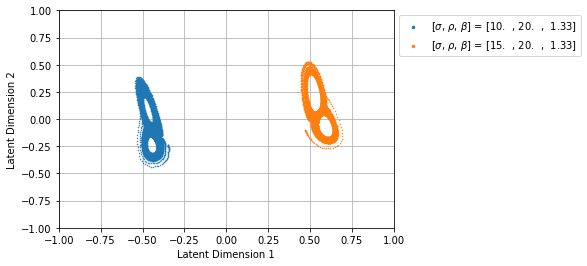

In [ ]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10)

In [ ]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

float

# LSTM

In [ ]:
# create data
# latent_states_all = net.encoder_net.predict(all_data)

In [ ]:
# parameters for creating sequences
dt_rnn = 0.25
T_sample_input = 10
T_sample_output = 10
T_offset = dt_rnn

In [ ]:
from tools.misc_tools import create_data_for_RNN

In [ ]:
if return_params_arr != False:
    params = params_arr
else:
    params = None

data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr,
    delta_t,
    params=params)

In [ ]:
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split

In [ ]:
idx = np.arange(data_rnn_input.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1 - test_split)*data_rnn_input.shape[0]))

training_data_rnn_input = data_rnn_input[idx[0:boundary]]
training_data_rnn_output = data_rnn_output[idx[0:boundary]]

testing_data_rnn_input = data_rnn_input[idx[boundary:]]
testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [ ]:
boundary

16274

In [ ]:
# train_dataset_rnn_input = tf.data.Dataset.from_tensor_slices(training_data_rnn_input)
# train_dataset_rnn_output = tf.data.Dataset.from_tensor_slices(training_data_rnn_output)

batch_size = 64

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# train_dataset_rnn = train_dataset_rnn.batch(BATCH_SIZE)
# test_dataset_rnn = test_dataset_rnn.batch(BATCH_SIZE)

In [ ]:
# saving the RNN
dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'rnn_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
print('RNN save directory : ' + dir_name_rnn)
os.makedirs(dir_name_rnn)
os.makedirs(dir_name_rnn+dir_sep+'plots')

sim_data = {
    'rho_arr':rho_arr,
    'sigma_arr':sigma_arr,
    'beta_arr':beta_arr,
    'x0':x0,
    'y0':y0,
    'z0':z0,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'dir_name_ae':dir_name_ae,
    'normalize_flag':normalize_flag
}


with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
    f.write(str(sim_data))
    
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'N':N,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr
}

with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
    f.write(str(RNN_specific_data))

RNN save directory : /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_rnn/rnn_000


In [ ]:
# Training parameters
learning_rate_list = [0.001, 0.0001, 0.00001]
epochs = 2000
patience = 50  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
lambda_reg = 1e-5  # weight for regularizer

In [ ]:
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size
}

with open(dir_name_rnn+'/training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [ ]:
from tools.LSTM_SingleStep_v1 import RNN_LSTM

In [ ]:
# Initialize network
rnn_layers_units = [2**6]*8
if return_params_arr != False:
    data_dim = 5
else:
    data_dim = 2

rnn_net = RNN_LSTM(
    data_dim=data_dim,
#     in_steps=int(T_sample_input // dt_rnn),
#     out_steps=int(T_sample_output // dt_rnn),
    dt_rnn=dt_rnn,
    lambda_reg=lambda_reg,
    reg_name='L2',
    rnn_layers_units=rnn_layers_units,
    dense_layer_act_func='linear',
    load_file=None
)

In [ ]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

# implementing early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=True,
    min_delta=min_delta
)

# time callback for each epoch
timekeeper_cb = mytimecallback()

# model checkpoint callback
dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
if not os.path.isdir(dir_name_ckpt):
    os.makedirs(dir_name_ckpt)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2,
    period=5  # saves every 5 epochs
)

# save losses callback
savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
savelosses_cb = SaveLosses(
    filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
    val_loss_arr=savelosses_cb_vallossarr,
    train_loss_arr=savelosses_cb_trainlossarr,
    total_epochs=epochs,
    period=10)

# training the network
val_loss_hist = []
train_loss_hist = []
lr_change=[0]
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    K.set_value(rnn_net.optimizer.lr, learning_rate)

    savelosses_cb.update_lr_idx(i)

    total_s_len = 80
    sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
    print('\n\n' + '-'*len(sep_lr_s))
    print('\n' + sep_lr_s+'\n')
    print('-'*len(sep_lr_s) + '\n\n')

    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])
    
    lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
227/227 [==============================] - 63s 248ms/step - loss: 0.0400 - val_loss: 0.0251
Epoch 2/2000
227/227 [==============================] - 55s 241ms/step - loss: 0.0222 - val_loss: 0.0208
Epoch 3/2000
227/227 [==============================] - 55s 243ms/step - loss: 0.0197 - val_loss: 0.0189
Epoch 4/2000
227/227 [==============================] - 54s 239ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 5/2000
227/227 [==============================] - ETA: 0s - loss: 0.0173 - tot_time: 0h 4m 41.7s

Epoch 5: val_loss improved from inf to 0.01691, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_rnn/rnn_000/checkpoints/checkpoints
227/227 [==============================] - 54s 239ms/step - loss: 0.

In [ ]:
test_loss = rnn_net.evaluate(
    testing_data_rnn_input, testing_data_rnn_output,
)

save_path = dir_name_rnn+dir_sep+'final_net'

if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(save_path+dir_sep+'losses.txt', 'w') as f:
    f.write(str({
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'lr_change':lr_change,
        'test_loss':test_loss
    }))

rnn_net.save_everything(file_name=save_path+dir_sep+'final_net')

In [ ]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()

# AE-RNN Combination